###  Import libraries


In [1]:
import tensorflow as tf
import os
import pandas as pd
import numpy as np
from tensorflow import keras
import matplotlib.pyplot as plt
%matplotlib inline

import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

### Read CSV

In [2]:
data = pd.read_csv("jena_climate_2009_2016.csv", parse_dates=True, index_col=0)

### Step 4: Limit dataset
- The dataset has metrics for every 10 minutes - we will limit it to only once per hour
    - HINT: **data[5::6]** will start at 5 and step 6.
        - **a[start:stop:step]** start through not past stop, by step

In [3]:
data = data[5::6]

### Step 5: Investigate data
- Call **corr()** on the data to see correlations
- Inspect what columns are correlated and not

### Step 6: Remove data
- Potential some data could be transformed **'wv (m/s)', 'max. wv (m/s)', 'wd (deg)'**
    - We will ignorre it

In [4]:
df = data.drop(['p (mbar)','wv (m/s)', 'max. wv (m/s)', 'wd (deg)'],axis = 1)

### Step 7: Add periodic time intervals
- Temperature is correlated to the time of day - e.g. it is warmer at mid day than at mid night
- Temperature is correlated to seasons (most places in the world) - e.g. it is warmer in summer than in winter
- The datetime index is not easy for the model to interpret, hence we can transform it into sinus and cosinus curves based on day and year.
- Do it like this
    - Assign the dataframe index to a variable, say, **timestamp_s**
    - Transform that by using **map(pd.Timestamp.timestamp)**
    - Use the period **day =** $24\times 60 \times 60$ and **year =** $(365.2425)\times$**day**
    - Make the following columns **'Day sin', 'Day cos', 'Year sin'**, and **'Year cos'** as follows:
        - e.g. **df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))**

In [5]:
timestamp_s = df.index
timestamp_s = timestamp_s.map(pd.Timestamp.timestamp)

In [6]:
day = 24*60*60
year = 365.2425 * day

In [7]:
 df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
 df['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
 df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
 df['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

### Step 8: Splitting data

#### About splitting
If you want to build a solid model you have to follow that specific protocol of splitting your data into three sets: One for training, one for validation and one for final evaluation, which is the test set.

The idea is that you train on your training data and tune your model with the results of metrics (accuracy, loss etc) that you get from your validation set.

Your model doesn't "see" your validation set and isn't in any way trained on it, but you as the architect and master of the hyperparameters tune the model according to this data. Therefore it indirectly influences your model because it directly influences your design decisions. You nudge your model to work well with the validation data and that can possibly bring in a tilt.

#### What to do?
- Use the length of data and split it into
    - 70% for training
    - 20% for validation
    - 10% for testing set

In [8]:
n = len(df)
train_df = df[:int(n*.7)]
val_df = df[int(n*.7):int(n*.9)]
test_df = df[int(n*.9):]

### Step 9: Normalize data
- Only normalize data based on training data
    - Notice you should only normalize the training data - because validation and test data could affect the normalization
- Get the mean and standard deviation of the data
    - HINT: Use **.mean()** and **.std()** on the dataframe.
- Noramlize the data as follows
    - **train_df = (train_df - train_mean) / train_std** (assuming naming fits)
    - HINT: The transformation of validation and test data is done similarly with **train_mean** and **train_std**.

In [9]:
train_mean = train_df.mean()
train_std = train_df.std()

In [10]:
train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

### Step 10: Create datasets


In [11]:
def create_dataset(df, input_width=24, offset=0, predict_column='T (degC)'):
    x = []
    y = []
    data_x = df.to_numpy()
    data_y = df[predict_column].to_numpy()
    
    for i in range(input_width, len(data_x) - offset):
        x.append(data_x[i - input_width:i,:])
        y.append(data_y[i + offset])
        
    x = np.array(x)
    y = np.array(y)
    
    return x, y.reshape(-1,1)

In [12]:
train_ds = create_dataset(train_df)
val_ds = create_dataset(val_df)
test_ds = create_dataset(test_df)

### Step 11: Create model
- Create the following model
    - **model = models.Sequential()**
    - **model.add(layers.LSTM(32, return_sequences=True, input_shape=train_ds[0].shape[1:]))**
    - **model.add(layers.Dense(units=1))**

In [13]:
inputs = keras.layers.Input(shape=(train_ds[0].shape[1], train_ds[0].shape[2]))
lstm_layer = keras.layers.LSTM(32)(inputs)
output = keras.layers.Dense(1)(lstm_layer)

model = keras.Model(inputs, output)
model.compile(keras.optimizers.Adam(0.001), loss="mse")
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 24, 14)]          0         
_________________________________________________________________
lstm (LSTM)                  (None, 32)                6016      
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 6,049
Trainable params: 6,049
Non-trainable params: 0
_________________________________________________________________


### Step 12: Train model
- Compile and fit the model
- Complie the model as follows
    - **model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])**
- Fit the model as follows
    - **model.fit(x=train_ds[0], y=train_ds[1], validation_data=(val_ds[0], val_ds[1]), epochs=5)**

In [14]:
history = model.fit(x=train_ds[0], y=train_ds[1], epochs=25, validation_data=val_ds)

Epoch 1/25
1533/1533 [==============================] - 11s 6ms/step - loss: 0.0166 - val_loss: 0.0071
Epoch 2/25
1533/1533 [==============================] - 9s 6ms/step - loss: 0.0071 - val_loss: 0.0071
Epoch 3/25
1533/1533 [==============================] - 8s 5ms/step - loss: 0.0068 - val_loss: 0.0063
Epoch 4/25
1533/1533 [==============================] - 9s 6ms/step - loss: 0.0067 - val_loss: 0.0062
Epoch 5/25
1533/1533 [==============================] - 8s 5ms/step - loss: 0.0066 - val_loss: 0.0067
Epoch 6/25
1533/1533 [==============================] - 9s 6ms/step - loss: 0.0066 - val_loss: 0.0063
Epoch 7/25
1533/1533 [==============================] - 10s 7ms/step - loss: 0.0065 - val_loss: 0.0062
Epoch 8/25
1533/1533 [==============================] - 10s 7ms/step - loss: 0.0065 - val_loss: 0.0061
Epoch 9/25
1533/1533 [==============================] - 8s 5ms/step - loss: 0.0064 - val_loss: 0.0060
Epoch 10/25
1533/1533 [==============================] - 9s 6ms/step - loss: 0.

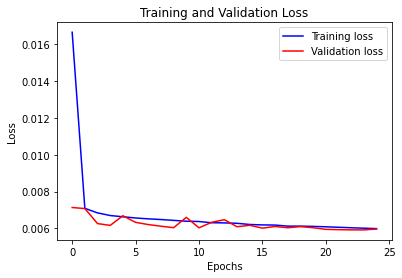

In [15]:
def visualize_loss(history, title):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(len(loss))
    plt.figure()
    plt.plot(epochs, loss, "b", label="Training loss")
    plt.plot(epochs, val_loss, "r", label="Validation loss")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

visualize_loss(history, "Training and Validation Loss")

### Step 13: Predict data
- Apply the model on the test data
    - HINT: Use **model.predict(x)**, where **x** is assigned to the test data.

In [16]:
x, y = test_ds

y_pred = model.predict(x)

y_pred.shape

(6986, 1)

### Step 14: Plot the result
- Plot a window of the data predicted together with the actual data.
- One way:
    - **fig, ax = plt.subplots()**
    - **ax.plot(y[i:i+96*2,0], c='g')**
    - **ax.plot(pred[i:i+96*2,-1,0], c='r')**
- It will plot a window of 96 hours, where you can index with **i** (**i=150** as an example) and **y** is the real values and **pred** are the predicted values

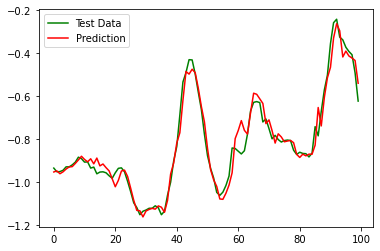

In [24]:
fig, ax = plt.subplots()

i = 150

ax.plot(y[0:100], c='g', label="Test Data")
ax.plot(y_pred[0:100], c='r', label="Prediction")
plt.legend()